# Short term trading strategies that work

In this notebook, strategies mentioned in the book 'Short term trading strategies that work' from Larry Connors are investigated. This book mainly focuses on short-term mean-reversion strategies in the US equity market.

In [1]:
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pytz
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest import (BacktestEngine, InstrumentDef,
                             Performance, signal, processing, rebase)
from vivace.backtest.engine import long_only_returns
from vivace.enums import Strategy, Weighting, PnLType

# Strategy 1
If the following conditions are met, go long the equity market for 5 days.
- It went down 3 days in a row
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [2]:
instruments = ['SPY', 'QQQ', '^GDAXI', '^N225']

In [3]:
def run_strat_1(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.ConsecutiveSign(n_consecutive=3, lookback_direction=-1, position=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine


def run_backtests(backtest_func, instruments):
    result = []

    for name in instruments:
        instrument = InstrumentDef(name, pnl_type=PnLType.ADJCLOSE_TO_ADJCLOSE.value)
        strat_engine = backtest_func(instrument)
        strat_equity_curve = strat_engine.calculate_equity_curve(calculate_net=False).rename(f'Strategy ({name})')
        long_only = long_only_returns(instrument, strat_equity_curve.index[0], strat_equity_curve.index[-1])
        long_only_equity_curve = long_only.add(1).cumprod().rename(f'Long-only ({name})')

        result.append(
            pd.concat((long_only_equity_curve, strat_equity_curve), axis=1).pipe(rebase)
        )
    return result

In [4]:
strategy_1_result = run_backtests(run_strat_1, instruments)

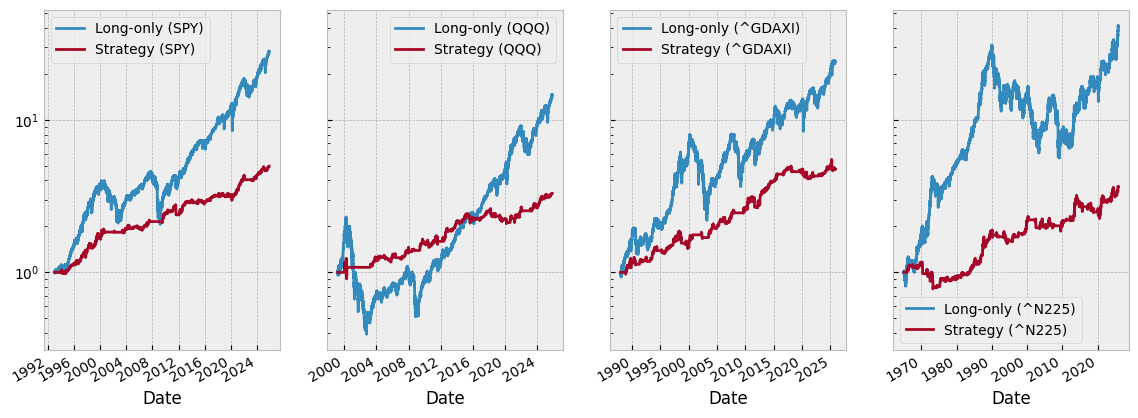

In [5]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.plot(ax=ax, logy=True)

In [6]:
pd.concat([i.pipe(Performance).summary() for i in strategy_1_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.101673,0.048958,0.100321,0.044755,0.083600,0.041065,0.062353,0.021789
Annualised vol,0.186582,0.071527,0.270897,0.097910,0.217406,0.082152,0.202668,0.076022
Sharpe ratio,0.544924,0.684474,0.370329,0.457099,0.384534,0.499872,0.307659,0.286618
Max drawdown,0.551895,0.140756,0.829639,0.265981,0.726848,0.233963,0.818712,0.335098
Calmar ratio,0.184226,0.347825,0.120921,0.168263,0.115017,0.175521,0.076159,0.065024
Skewness,-0.010416,-0.791467,0.230450,1.518627,-0.126199,-1.798224,-0.199931,-3.091559
Kurtosis,11.824233,39.820064,7.135635,70.781596,6.625464,65.497219,9.307028,111.799783
Worst return,-0.109424,-0.072473,-0.119788,-0.086647,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.086647,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197933,-0.081136,-0.246190,-0.246190,-0.216097,-0.128878,-0.243342,-0.127345


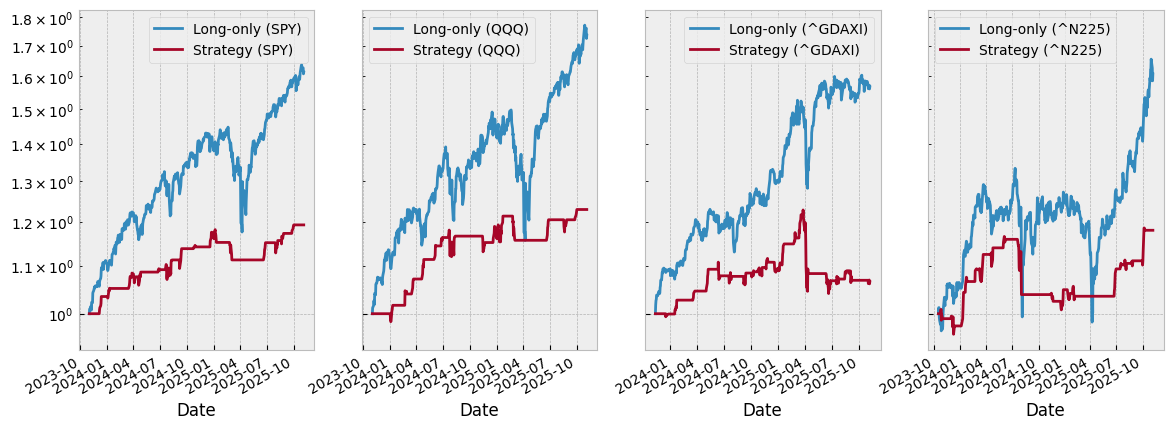

In [7]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 2

If the following conditions are met, go long the equity market for 5 days.
- It the market made new 10-day lows
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [8]:
def run_strat_2(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.LocalMinimum(lookback=10, shift=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [9]:
strategy_2_result = run_backtests(run_strat_2, instruments)

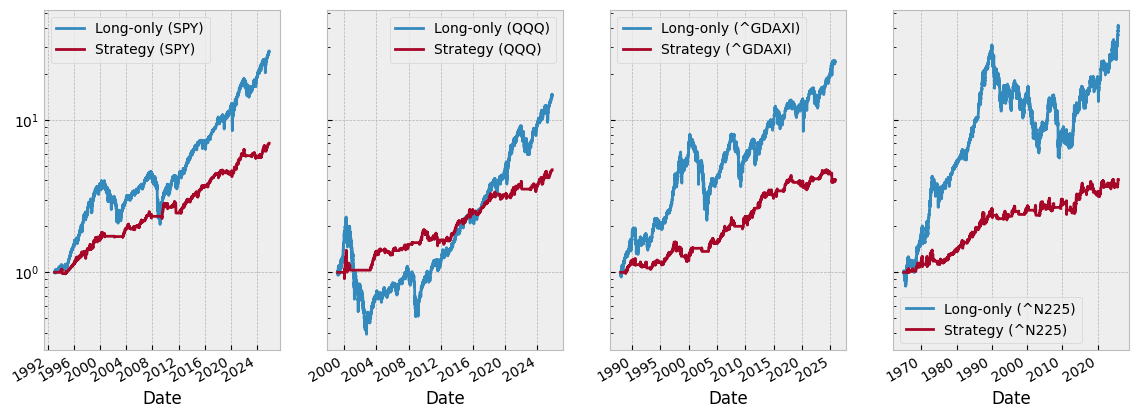

In [10]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.plot(ax=ax, logy=True)

In [11]:
pd.concat([i.pipe(Performance).summary() for i in strategy_2_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.101673,0.059514,0.100321,0.058183,0.083600,0.036701,0.062353,0.023586
Annualised vol,0.186582,0.081454,0.270897,0.112638,0.217406,0.088793,0.202668,0.087158
Sharpe ratio,0.544924,0.730652,0.370329,0.516546,0.384534,0.413339,0.307659,0.270615
Max drawdown,0.551895,0.163106,0.829639,0.282275,0.726848,0.256756,0.818712,0.219014
Calmar ratio,0.184226,0.364882,0.120921,0.206121,0.115017,0.142943,0.076159,0.107694
Skewness,-0.010416,-0.575390,0.230450,0.681886,-0.126199,-0.309158,-0.199931,-2.364709
Kurtosis,11.824233,27.362371,7.135635,45.563691,6.625464,16.724843,9.307028,79.216405
Worst return,-0.109424,-0.072473,-0.119788,-0.086647,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.086647,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1w return,-0.197933,-0.081136,-0.246190,-0.246190,-0.216097,-0.087830,-0.243342,-0.127345


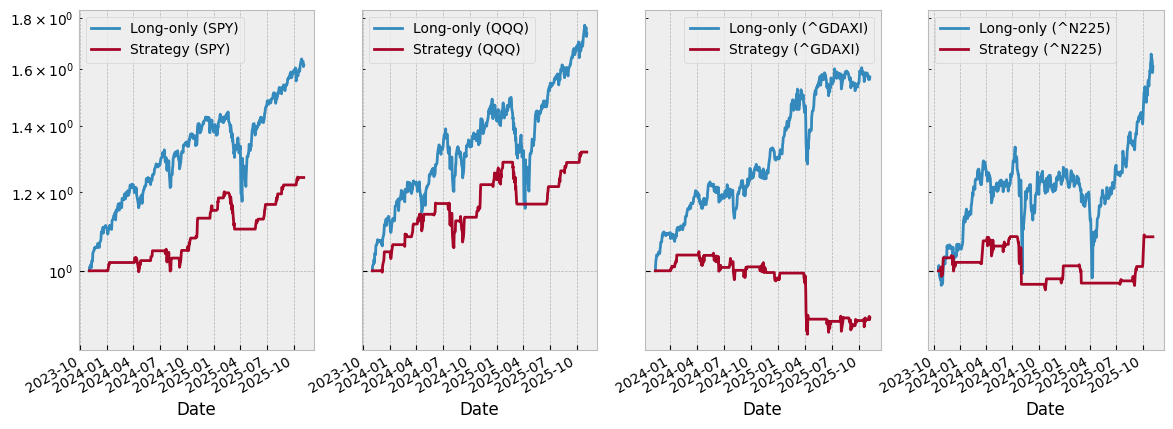

In [12]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 3

This strategy is the so-called "Double 7's strategy".

In [13]:
def run_strat_3(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Double7Connors(),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [14]:
strategy_3_result = run_backtests(run_strat_3, instruments)

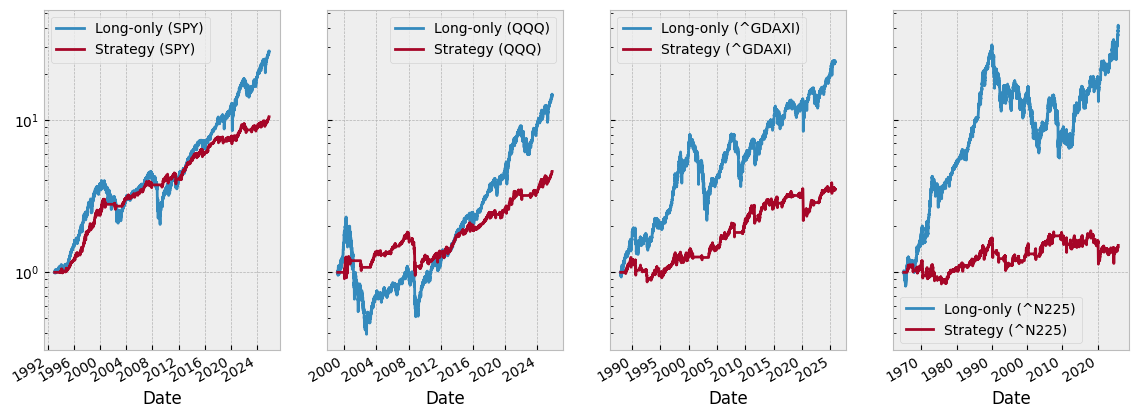

In [15]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.plot(ax=ax, logy=True)

In [16]:
pd.concat([i.pipe(Performance).summary() for i in strategy_3_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.101673,0.071705,0.100321,0.057205,0.083600,0.032907,0.062353,0.006853
Annualised vol,0.186582,0.097503,0.270897,0.140957,0.217406,0.116884,0.202668,0.107985
Sharpe ratio,0.544924,0.735415,0.370329,0.405835,0.384534,0.281537,0.307659,0.063462
Max drawdown,0.551895,0.153225,0.829639,0.480135,0.726848,0.382193,0.818712,0.395910
Calmar ratio,0.184226,0.467973,0.120921,0.119144,0.115017,0.086101,0.076159,0.017309
Skewness,-0.010416,-0.308858,0.230450,0.608150,-0.126199,-1.175360,-0.199931,-1.691502
Kurtosis,11.824233,17.433147,7.135635,32.345086,6.625464,36.148605,9.307028,51.752074
Worst return,-0.109424,-0.072473,-0.119788,-0.089556,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.089556,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197933,-0.111611,-0.246190,-0.246190,-0.216097,-0.200123,-0.243342,-0.159939


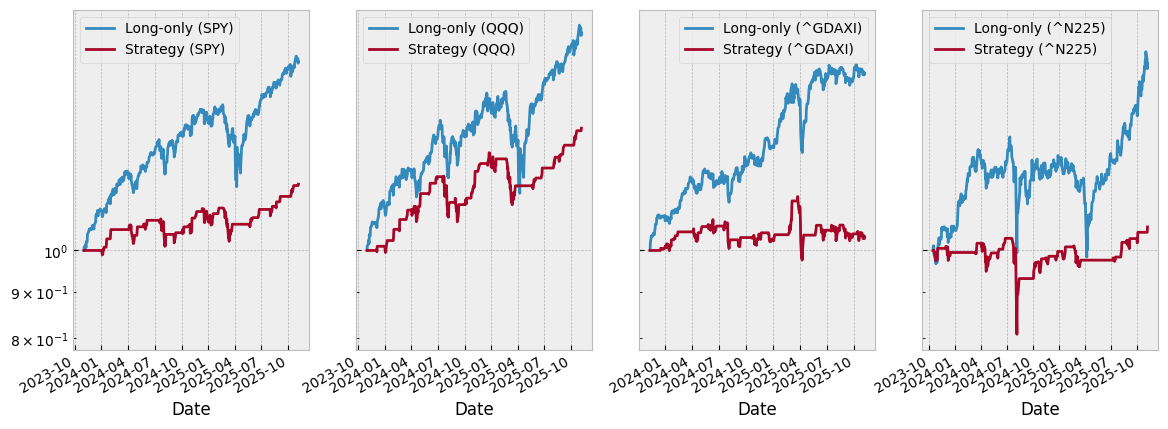

In [17]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 4
Month-end strategy which goes long when the following conditions are met:
- n days before month-end
    - (optional) only do so when the previous day is down
- The price is above 200 day MA

In [18]:
def run_strat_4(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.MonthEndLong(n_before=5, n_after=0, is_prev_neg=True),
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [19]:
strategy_4_result = run_backtests(run_strat_4, instruments)

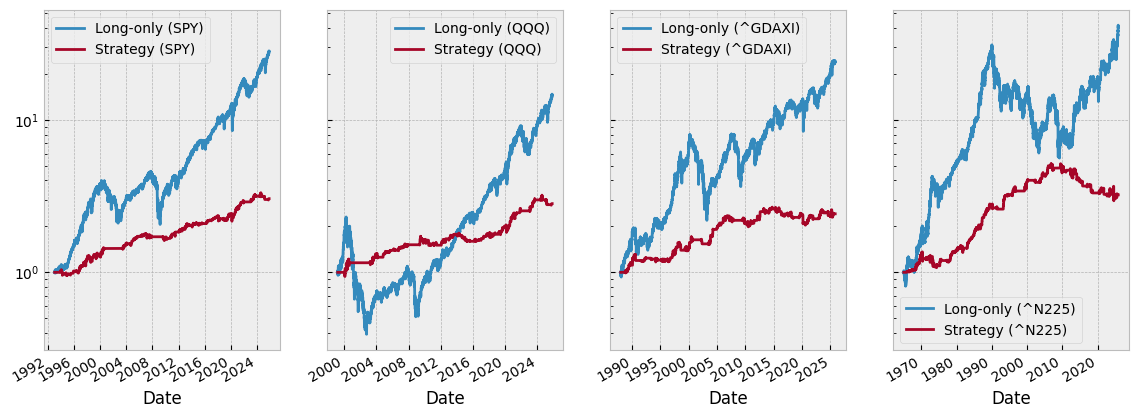

In [20]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.plot(ax=ax, logy=True)

In [21]:
pd.concat([i.pipe(Performance).summary() for i in strategy_4_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.101673,0.033965,0.100321,0.038961,0.083600,0.023255,0.062353,0.019698
Annualised vol,0.186582,0.061041,0.270897,0.080469,0.217406,0.067101,0.202668,0.063036
Sharpe ratio,0.544924,0.556422,0.370329,0.484172,0.384534,0.346567,0.307659,0.312485
Max drawdown,0.551895,0.111611,0.829639,0.140945,0.726848,0.238856,0.818712,0.428543
Calmar ratio,0.184226,0.304313,0.120921,0.276424,0.115017,0.097359,0.076159,0.045965
Skewness,-0.010416,-0.802259,0.230450,0.406670,-0.126199,-0.429983,-0.199931,-2.542180
Kurtosis,11.824233,46.743446,7.135635,39.789777,6.625464,28.240869,9.307028,151.433192
Worst return,-0.109424,-0.072473,-0.119788,-0.057516,-0.131434,-0.049530,-0.149009,-0.123958
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.057516,-0.131434,-0.049530,-0.149009,-0.123958
Worst 1w return,-0.197933,-0.111611,-0.246190,-0.106267,-0.216097,-0.124379,-0.243342,-0.127345


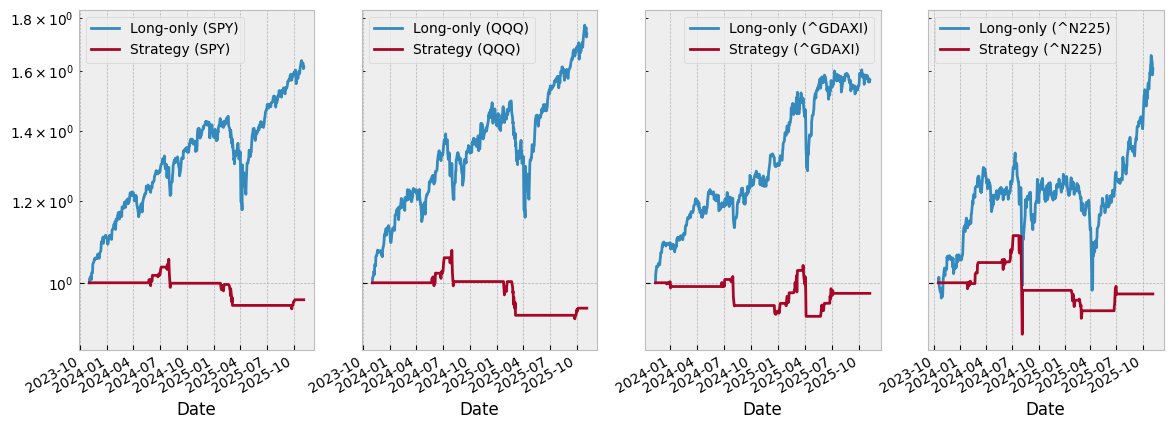

In [22]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Reference
- Connors, L.A. and Alvarez, C., 2009. Short Term Trading Strategies that Work: A Quantified Guide to Trading Stocks and ETFs. TradingMarkets Publishing Group.

In [23]:
print(f'Updated: {datetime.now(pytz.utc):%d-%b-%Y %H:%M}')

Updated: 07-Nov-2025 00:42
